# Tamil Handwritten Character Recognition

## Import Libraries

In [ ]:
import os
import gc
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from skimage import filters
from imutils import contours
from scipy.special import softmax
from google.colab.patches import cv2_imshow
from IPython.display import Markdown, display
from keras.models import Sequential, model_from_json
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report,confusion_matrix
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization

## Mount the Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Point to Working Directory

In [ ]:
%cd /content/drive/MyDrive/AI/

/content/drive/MyDrive/AI


## Load Model Architecture with the trained weights

In [ ]:
# Load Model Architecture (JSON File)
json_file = open("/content/drive/MyDrive/AI/model/model_30.json", 'r')
loaded_model_json = json_file.read()
json_file.close()
# Load the trained model weights (h5 file)
loaded_model = model_from_json(loaded_model_json)
# Initiate the model with the loaded weights
loaded_model.load_weights("/content/drive/MyDrive/AI/model/model_weights_30.h5")
print("Loaded model from disk")

Loaded model from disk


## Model Compilation
* Compile the model with the below metioned parameters
* Use `sparse_categorical_crossentropy` as the loss function since the Outputs are integers and not one-hot encoded vectors.
* `Adam` Optimizer yielded the best result.
* `Accuracy` as the error metric.

In [ ]:
loaded_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Utility Functions

`print_big(char)`: Function to print the character in a bigger size

In [ ]:
def print_big(char):
    display(Markdown(f"<h1>{char}</h1>"))

`printchar(index, word)`: Function to print the unicode equivalent of the predicted class (`index`) and concatenate as a single tamil word in case of words with an auxiliary character

In [ ]:
def printchar(index,word):
  # TamilChar.csv is the dataset which contains the unicode equivalents for a given character class
  df = pd.read_csv('/content/drive/MyDrive/AI/TamilChar.csv', header=0)
  # Read the corresponding the unicode equivalent
  code_list = df['Unicode'].values[index]
  chars_together = ""
  # Split into unit characters
  code_list = code_list.split()
  for code in code_list:
    # Convert all the unit characters to hexadecimal equivalent
    hex_str = "0x" + code
    # Convert to integer base 16
    char_int = int(hex_str, 16)
    # Convert to corresponding character
    character = chr(char_int)
    # Concatenate the unit characters to constitute the word
    chars_together += character
  word += chars_together
  return word
  # print_big(chars_together)

`predictions_word(img2, word)`: Function to predict the class of a given word and print the charater equivalent

In [ ]:
def predictions_word(img2,word):
    # Convert the grayImage to (128,128) dimension and normalize it
    grayImage = (cv2.resize(img2,(128,128))/255.0).astype(np.float32)
    sample_img = [grayImage]
    sample_img = np.array(sample_img)

    # Predict the class of the word
    predictions = loaded_model.predict(sample_img)
    # Take the class with maximum probability
    predictions_abs = np.array([np.argmax(i) for i in predictions])

    # f, axarr = plt.subplots(1,1)
    # axarr[0].imshow(img_arr,cmap="gray")
    # axarr.imshow(grayImage,cmap="gray")

    # Retrieve the corresponding character of the class
    word = printchar(predictions_abs[0],word)
    return word

`sharpening(img, word)` - Function to find the contours of a word, redraw them on white background and send this reconstructed image for character recognition.



In [ ]:
def sharpening(img,word):
  # Create a blank 3-channel image of the same size as the grayscale image
  height, width = img.shape
  rgb = np.zeros((height, width, 3), dtype=np.uint8)

  # Copy the grayscale image to all 3 channels of the RGB image
  rgb[:,:,0] = img
  rgb[:,:,1] = img
  rgb[:,:,2] = img

  # Threshold the image to create a binary mask
  _, thresh = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY_INV)

  # Find the contours of the binary mask
  contours, _ = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

  # Create a blank white image of the same size as the input image
  white = np.full_like(rgb, (255, 255, 255))

  # Draw the contours onto the white image with a thickness of 5 pixels
  cv2.drawContours(white, contours, -1, (0, 0, 0), -1)

  # Apply a sharpening filter to the image
  kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
  sharpened = cv2.filter2D(white, -1, kernel)

  # Display the sharpened image
  cv2_imshow(sharpened)

  # Use the reconstructed sharpened image for character recognition
  word = predictions_word(sharpened,word)

  # Return predicted classes
  cv2.waitKey(0)
  return word

`bounding_box(path)` - Function to extract individual characters from a tamil sentence using connect component analysis and process each character further



In [ ]:
def bounding_box(path):

  # Read the image in grayscale
  img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
  # Use Contrast Limited Adaptive Histogram Equalization to contrast the image and prevent over-amplification
  clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
  img = clahe.apply(img)
  # Smoothen the image using Gaussian and Median Blue to remove Image noises
  img = cv2.GaussianBlur(img, (3, 3), 0)
  img = cv2.medianBlur(img, 3)
  # Apply Binary Thresholding to sharpen the image
  _, binary = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
  # Apply Connected Component Analysis to Split the text into its constituent characters
  num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary, connectivity=8, ltype=cv2.CV_32S)
  # Set a minimum size threshold to filter out small connected components

  min_size = 200  # adjust as needed based on the expected size of the characters
  # Loop over the connected components and save each character image without the bounding box
  bboxes = []
  for i in range(1, num_labels):
      area = stats[i, cv2.CC_STAT_AREA]
      if area < min_size:
          continue
      x, y, w, h = stats[i, cv2.CC_STAT_LEFT], stats[i, cv2.CC_STAT_TOP], stats[i, cv2.CC_STAT_WIDTH], stats[i, cv2.CC_STAT_HEIGHT]
      # cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
      bbox = (x, y, w, h)
      bboxes.append(bbox)

  cv2_imshow(img)
  # Sort the bounding boxes by their x-coordinate values
  bboxes = sorted(bboxes, key=lambda x: x[0])

  aspect_ratio_threshold = 0.2
  # Apply Padding to the images by adjusting the aspect ratio
  word = ""
  for i, bbox in enumerate(bboxes):
      x, y, w, h = bbox
      aspect_ratio = float(w) / h
      if aspect_ratio < aspect_ratio_threshold or aspect_ratio > 1/aspect_ratio_threshold:
            continue
      char_img = img[y:y+h, x:x+w]
      sharpening(char_img)

`bounding_box2(path)` - [*Version 2 of bounding_box(path)*] Function to extract individual characters from a tamil sentence using connect component analysis and process each character further



In [ ]:
def bounding_box2(path):
  # Read the image in grayscale
  img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
  # Use Contrast Limited Adaptive Histogram Equalization to contrast the image and prevent over-amplification
  clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
  img = clahe.apply(img)
  # Smoothen the image using Gaussian and Median Blue to remove Image noises
  img = cv2.GaussianBlur(img, (3, 3), 0)
  img = cv2.medianBlur(img, 3)
  # Apply Binary Thresholding to sharpen the image
  _, binary = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
  # Apply Connected Component Analysis to Split the text into its constituent characters
  num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary, connectivity=8, ltype=cv2.CV_32S)
  # Set a minimum size threshold to filter out small connected components
  min_size = 200  # adjust as needed based on the expected size of the characters
  # Loop over the connected components and save each character image without the bounding box
  bboxes = []
  for i in range(1, num_labels):
      area = stats[i, cv2.CC_STAT_AREA]
      if area < min_size:
          continue
      x, y, w, h = stats[i, cv2.CC_STAT_LEFT], stats[i, cv2.CC_STAT_TOP], stats[i, cv2.CC_STAT_WIDTH], stats[i, cv2.CC_STAT_HEIGHT]
      # cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
      bbox = (x, y, w, h)
      bboxes.append(bbox)
  cv2_imshow(img)
  # Sort the bounding boxes by their x-coordinate values
  bboxes = sorted(bboxes, key=lambda x: x[0])
  # Apply Padding to the images to set the aspect ratio and prevent over-magnification of the images
  aspect_ratio_threshold = 0.2
  word = ""
  indices = []

  for i in range(len(bboxes)-1):
    if(i in indices):
      continue
    x1, y1, w1, h1 = bboxes[i]
    x2, y2, w2, h2 = bboxes[i+1]
    # Ignore proper images
    aspect_ratio = float(w1) / h1
    if aspect_ratio < aspect_ratio_threshold or aspect_ratio > 1/aspect_ratio_threshold:
          continue
    # Pad the over magnified images with the repsective aspect ratio threshold
    if(x2>x1 and x2<x1+w1 and x2+w2>x1 and x2+w2<x1+w1):
      x,y,w,h = x1,y2,w1,h1+h2+25
      # print(i,i+1)
      # print(i,x1,x1+w1,y1,y1+h1,i+1,x2,x2+w2,y2,y2+h2)
      # print(i,x1,y1,w1,h1,i+1,x2,y2,w2,h2)
      char_img = img[y:y+h, x:x+w]
      word = sharpening(char_img,word)
      indices.append(i+1)
    else:
      # Make predictions with proper images
      char_img = img[y1:y1+h1, x1:x1+w1]
      word = sharpening(char_img,word)
  # Make predictions with padded images
  if(len(bboxes)-1 not in indices):
    x1, y1, w1, h1 = bboxes[-1]
    char_img = img[y1:y1+h1, x1:x1+w1]
    word = sharpening(char_img,word)
  return word

# Make Predictions

### Workflow:
1. `bounding_box2()` - slices the image into individual characters  
2. `sharpening()` - redraws the contours of the character
3. `predictions_word()` - predicts and maps the classes with its char equivalents
4. `print_char()` - prints the character


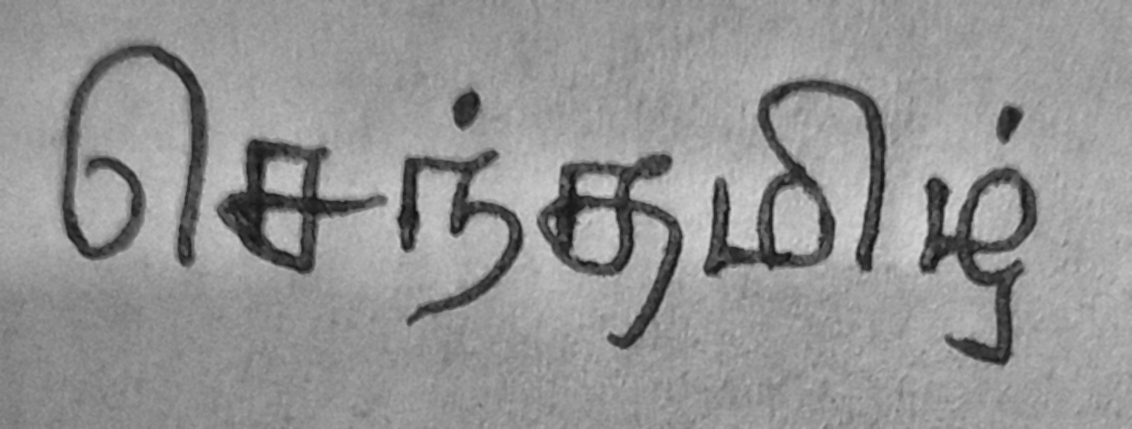

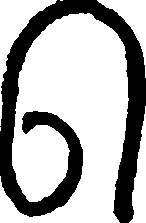

1/1 [==============================] - 0s 305ms/step


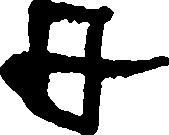

1/1 [==============================] - 0s 93ms/step


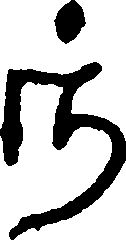

1/1 [==============================] - 0s 171ms/step


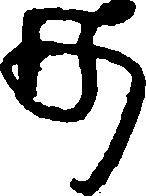

1/1 [==============================] - 0s 110ms/step


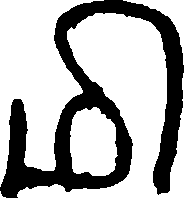

1/1 [==============================] - 0s 146ms/step


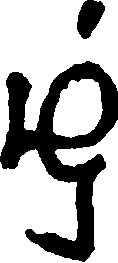

1/1 [==============================] - 0s 118ms/step


<h1>ெசந்தமிழ்</h1>

In [ ]:
print_big(bounding_box2("/content/drive/MyDrive/AI/tamil.jpg"))